1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 128, 100, 100])


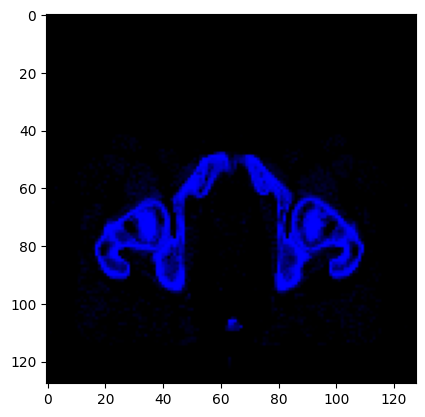

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------


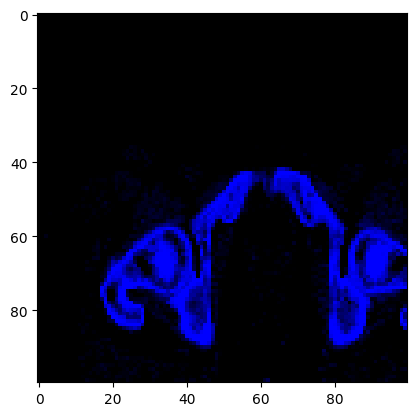

--------------------------------------------------------------


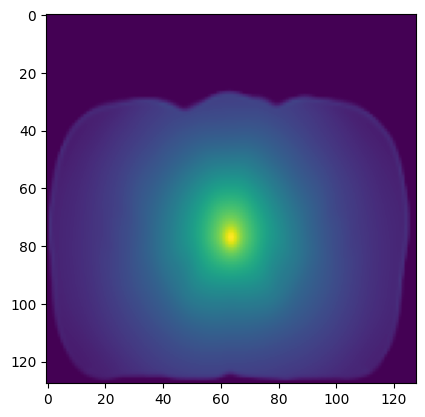

--------------------------------------------------------------


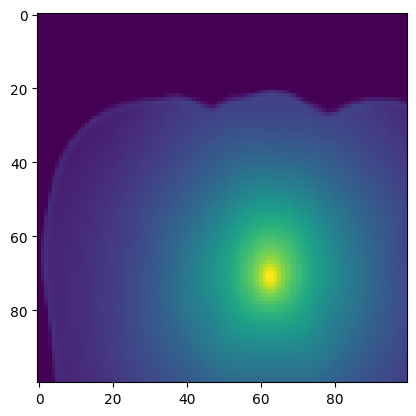

[tensor([[[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
           [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
           [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]

In [118]:
import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import os
import os.path
from __future__ import print_function
import torch
import numpy as np
from skimage.transform import rescale
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# funciones utiles para cargar el dataset
def is_image_file(filename, filetypes=IMG_EXTENSIONS):
    return any(filename.endswith(extension) for extension in filetypes)


def make_dataset(dir, filetypes=IMG_EXTENSIONS):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname, filetypes):
                path = os.path.join(root, fname)
                images.append(path)

    return images
# definjcion de las transformaciones para ct , dosis y data augmentation 
def get_transform_dosis(dim_3D):
    transform_list = []
    transform_list.append(transforms.Lambda(lambda dose_val : transformacion_valores_tensores_dosis(dose_val)))
    transform_list.append(transforms.Lambda(lambda dose_val : normalized(dose_val)))
    transform_list.append(transforms.Lambda(lambda dose_val : trilinear_interpolation(dose_val, dim_3D))) # que la medida sea parametro

    return transforms.Compose(transform_list)
    
# compose compone varias funciones juntas, admite una lista de transformaciones 

def transformacion_valores_tensores_dosis(dose_val):
    dose_val = dose_val.numpy()
    if dose_val.dtype == np.uint8 or dose_val.dtype == np.uint16:
        dose_val= dose_val / 256

    dose_val = torch.from_numpy(dose_val).float()

    return dose_val

def normalized(B):
    B = B.unsqueeze(0) 
    B.sub_(0.5).div_(0.5)
    return B

def get_transform_ct(dim_3D):
    transform_list = []
    transform_list.append(transforms.Lambda(lambda ct_image : transformacion_valores_tensores_ct(ct_image)))
    transform_list.append(transforms.Lambda(lambda ct_image : normalize3d(ct_image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))))
    transform_list.append(transforms.Lambda(lambda ct_image : trilinear_interpolation(ct_image, dim_3D)))

    return transforms.Compose(transform_list)
    
# compose compone varias funciones juntas, admite una lista de transformaciones 

def transformacion_valores_tensores_ct(ct_image):
    ct_image = ct_image.numpy()
    if ct_image.dtype == np.uint8 or ct_image.dtype == np.uint16:
        ct_image = ct_image / 256
    ct_image = torch.from_numpy(ct_image).float()

    return ct_image

def normalize3d(img, mean, std):
    ''' Normalizes a voxel Tensor (C x D x H x W) by mean and std. '''
    if len(mean) < 3 or len(std) < 3:
        raise TypeError('not enough means and standard deviations')
    for t, m, s in zip(img, mean, std):
        t.sub_(m).div_(s)
    return img

def trilinear_interpolation(tensor, target_size):
    # Redimensionar usando interpolación trilineal con el tamaño objetivo
    tensor_resized = F.interpolate(tensor.unsqueeze(0), size=target_size, mode='trilinear', align_corners=False).squeeze(0)
    return tensor_resized

def get_transform_data_augmentation():
    
    ramdom = random.randint(0, 5)
    # flip and crop
    if ramdom == 0 or ramdom == 1:
        transform = transforms.Compose(
            [transforms.RandomCrop(100),
             transforms.RandomHorizontalFlip(1)])
    # flip
    elif ramdom == 2 or ramdom == 3: 
        transform = transforms.RandomHorizontalFlip(1)
    #crop
    elif ramdom == 4 or ramdom == 5: 
        transform = transforms.RandomCrop(100)
    print(ramdom)
    return transform


# ______________________________________________________________________________________--
# codigo de dataset y dataloader 

class CustomImageDataset(data.Dataset):

    def __init__(self, ruta, transform, target_transform, transform_data_augmentation):
        self.dir_AB = ruta
        self.transform_ct = transform
        self.target_transform = target_transform 
        slice_filetype = ['.pt'] 
        self.AB_paths = sorted(make_dataset(self.dir_AB, slice_filetype))
        self.longuitud = len(self.AB_paths)
        self.transform_data_augmentation = transform_data_augmentation
        
        
    def __getitem__(self, index):
        AB_path = self.AB_paths[index]
        #Cargar el archivo utilizando el nombre de la variable
        loaded = torch.load(AB_path)
        # Acceder a los tensores por separado
        tensor_ct = loaded["imagen"]
        dose_val = loaded["dosis"]
        tensor_ct = self.transform_ct(tensor_ct)
        dose_val = self.target_transform(dose_val)
        
        tensor_transform = torch.zeros([3, 257, 128, 128])
        tensor_transform[:,0:128,:,:] = tensor_ct 
        tensor_transform[0,129:257,:,:] = dose_val 
        
        tensor_transform = self.transform_data_augmentation(tensor_transform)

        tensor_ct2 = tensor_transform[:,0:128,:,:]
        dose_val2 = (tensor_transform[0,129:257,:,:]).unsqueeze(0) 
        print(dose_val2.size())
        
        corte = tensor_ct[:, 40, :,:]
        corte = corte.permute(1,2,0)
        plt.imshow(corte)
        plt.show()
        print('--------------------------------------------------------------')
        corte = tensor_ct2[:, 40, :,:]
        corte = corte.permute(1,2,0)
        plt.imshow(corte)
        plt.show()
        print('--------------------------------------------------------------')
        corte = dose_val[:, 20, :,:]
        corte = corte.permute(1,2,0)
        plt.imshow(corte)
        plt.show()
        print('--------------------------------------------------------------')
        corte = dose_val2[:, 20, :,:]
        corte = corte.permute(1,2,0)
        plt.imshow(corte)
        plt.show()
        
        return tensor_ct2, dose_val2

    def __len__(self):
        return len(self.AB_paths)

    def name(self):
        return 'CustomImageDataset'

# creacion de dataset y dataloader para train y test
dim_3D = [128,128,128]
dataset = CustomImageDataset(r"C:\Users\ortma\Desktop\FACULTAD\PI\TENSORES PACIENTES", get_transform_ct(dim_3D), get_transform_dosis(dim_3D), get_transform_data_augmentation())

generator1 = torch.Generator().manual_seed(42)

dataset_train, dataset_test = random_split(dataset, [0.7, 0.3], generator=generator1)

train_dataloader = DataLoader(dataset_train, batch_size=1, shuffle=True) # el paper lo pone en 1. 
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=True)

next(iter(test_dataloader))





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 128, 100, 100])


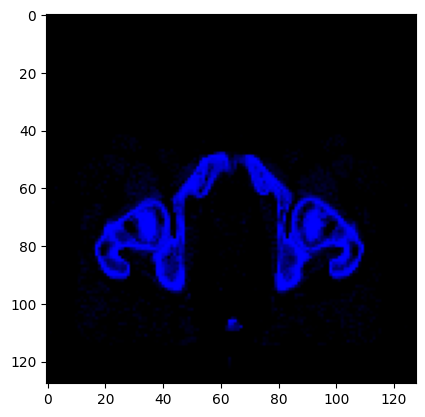

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------


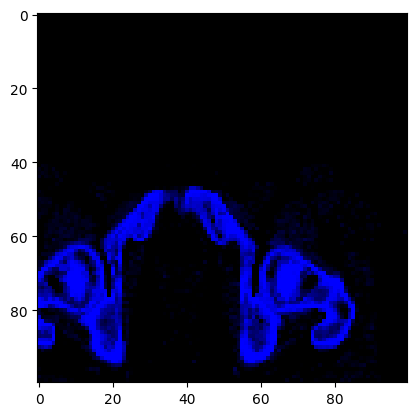

--------------------------------------------------------------


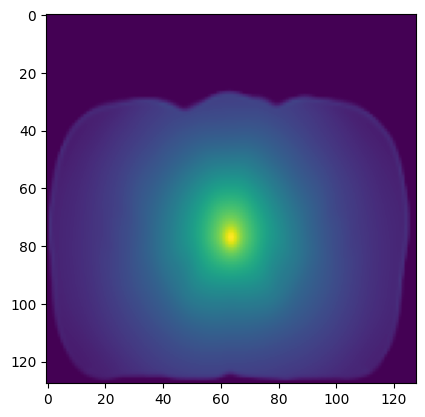

--------------------------------------------------------------


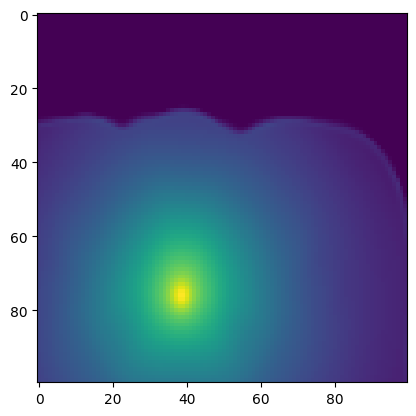

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([1, 3, 128, 100, 100])
Labels batch shape: torch.Size([1, 1, 128, 100, 100])


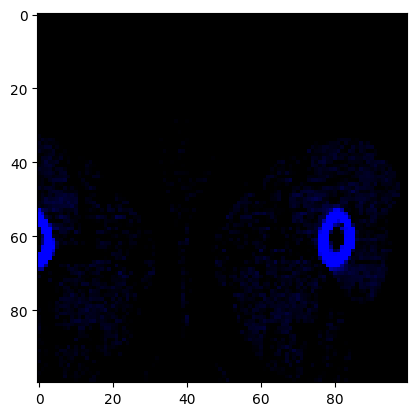

In [117]:
# Display image and label.
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
corte = img[:, 0, :,:]
corte = corte.permute(1,2,0)
plt.imshow(corte)
plt.show()